In [1]:
# import libraries
import pandas as pd
from pandas import DataFrame, merge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing

In [2]:
# read in the data file
FF1 = pd.read_csv('FoodFuel.csv')

In [3]:
# create datetime 
FF1['Date'] = pd.to_datetime(FF1.Date, utc=True)

In [4]:
# set index to date
FF1.set_index('Date', inplace=True)

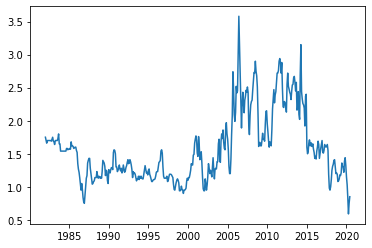

In [5]:
plt.plot(FF1.Ethanol)

In [6]:
#check for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test for:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

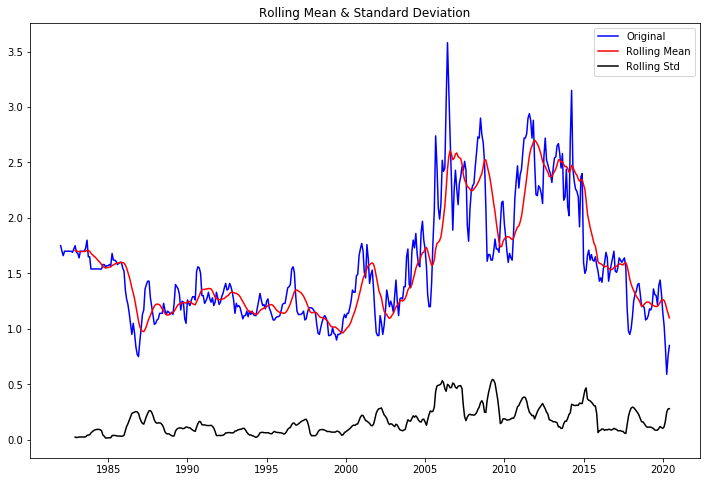

Results of Dickey-Fuller Test for:
Test Statistic                  -2.111951
p-value                          0.239736
#Lags Used                       6.000000
Number of Observations Used    455.000000
Critical Value (1%)             -3.444804
Critical Value (5%)             -2.867913
Critical Value (10%)            -2.570165
dtype: float64


In [7]:
test_stationarity(FF1.Ethanol)

In [8]:
# take first difference then re-test for stationarity
FF1['fdif_ethanol'] = FF1.Ethanol - FF1.Ethanol.shift(1)

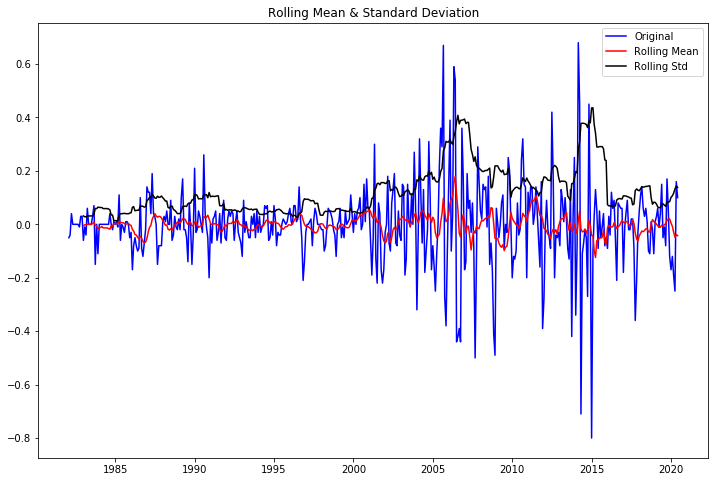

Results of Dickey-Fuller Test for:
Test Statistic                -1.148966e+01
p-value                        4.770656e-21
#Lags Used                     5.000000e+00
Number of Observations Used    4.550000e+02
Critical Value (1%)           -3.444804e+00
Critical Value (5%)           -2.867913e+00
Critical Value (10%)          -2.570165e+00
dtype: float64


In [9]:
test_stationarity(FF1.fdif_ethanol.dropna(inplace=False))

In [10]:
# take seasonal difference then re-test for stationarity
FF1['annual_change_ethanol'] = FF1.Ethanol - FF1.Ethanol.shift(12)

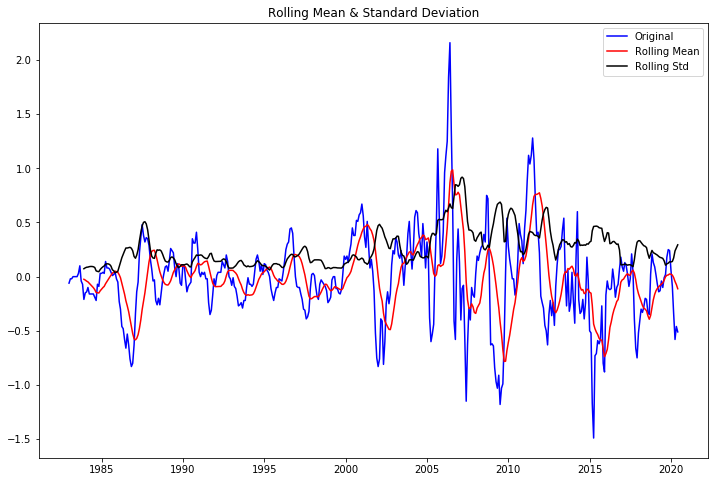

Results of Dickey-Fuller Test for:
Test Statistic                  -4.468985
p-value                          0.000224
#Lags Used                      14.000000
Number of Observations Used    435.000000
Critical Value (1%)             -3.445473
Critical Value (5%)             -2.868207
Critical Value (10%)            -2.570321
dtype: float64


In [11]:
test_stationarity(FF1.annual_change_ethanol.dropna(inplace=False))

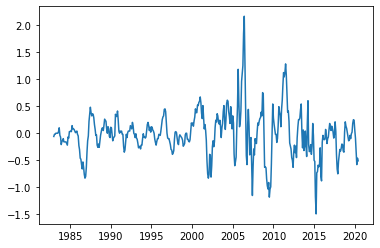

In [12]:
plt.plot(FF1.annual_change_ethanol)

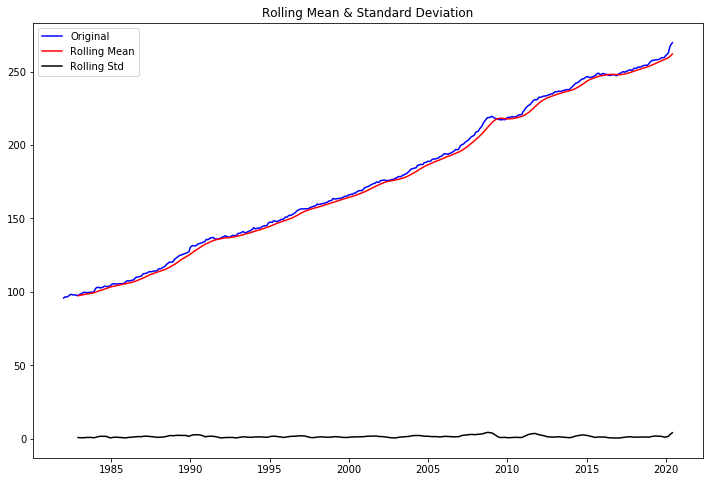

Results of Dickey-Fuller Test for:
Test Statistic                   1.089340
p-value                          0.995125
#Lags Used                      14.000000
Number of Observations Used    447.000000
Critical Value (1%)             -3.445064
Critical Value (5%)             -2.868028
Critical Value (10%)            -2.570226
dtype: float64


In [13]:
# test stationartity for food
test_stationarity(FF1.Food)

In [14]:
# take yearly difference
FF1['annual_change_food'] = FF1.Food - FF1.Food.shift(12)

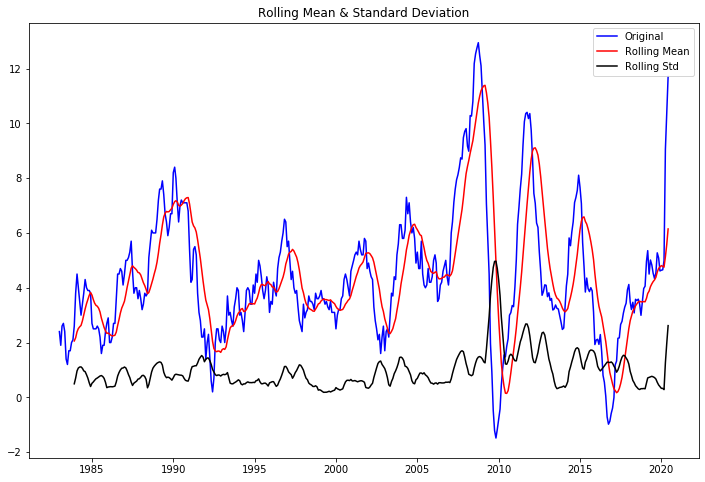

Results of Dickey-Fuller Test for:
Test Statistic                  -4.555883
p-value                          0.000156
#Lags Used                      18.000000
Number of Observations Used    431.000000
Critical Value (1%)             -3.445614
Critical Value (5%)             -2.868269
Critical Value (10%)            -2.570354
dtype: float64


In [15]:
test_stationarity(FF1.annual_change_food.dropna(inplace=False))

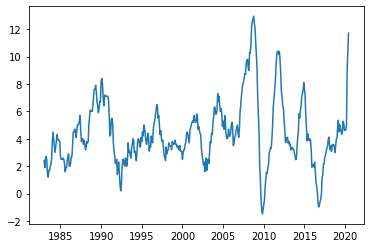

In [16]:
plt.plot(FF1.annual_change_food)

In [17]:
# split the time series data 80% train, 20% test - calculate the 80% mark
len(FF1.Ethanol) * 0.8

369.6

In [18]:
# find location of index 370 - November 2012
FF1.iloc[370]

Corn                                 7.020000
Ethanol                              2.430000
Blender_cost                         2.430000
Gasoline                             2.870000
Corn_cost_per_gallon                 2.600000
Ethanol_geg                          3.626866
Year                              2012.000000
Month                               11.000000
Alcoholic beverages at home        192.930000
Beef and veal                      265.638000
Breakfast cereal                   228.942000
Cakes, cupcakes, and cookies       271.437000
Carbonated drinks                  159.373000
Cereals and cereal products        231.910000
Dairy and related products         218.921000
Fats and oils                      231.588000
Fish and seafood                   266.862000
Flour and prepared flour mixes     244.726000
Food                               234.896000
Frozen vegetables                  203.932000
Fruits and vegetables              284.367000
Ham                               

In [19]:
# drop first year to remove NaNs
X_train = FF1[['annual_change_ethanol']].iloc[12:370]
X_test = FF1[['annual_change_ethanol']].iloc[370:]
y_train = FF1[['annual_change_food']].iloc[12:370]
y_test = FF1[['annual_change_food']].iloc[370:]

In [20]:
y_train.min()

annual_change_food   -1.484
dtype: float64

In [21]:
X_train = FF1[['annual_change_ethanol']].iloc[12:370]
X_train

,annual_change_ethanol
Date,
1983-01-01 00:00:00+00:00,-0.06
1983-02-01 00:00:00+00:00,-0.02
1983-03-01 00:00:00+00:00,-0.02
1983-04-01 00:00:00+00:00,0.00
1983-05-01 00:00:00+00:00,0.00
...,...
2012-06-01 00:00:00+00:00,-0.63
2012-07-01 00:00:00+00:00,-0.35
2012-08-01 00:00:00+00:00,-0.22


In [22]:
# scale both Ethanol and Food
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [23]:
X_train_scaled

array([[-0.20245302],
       [-0.10571871],
       [-0.10571871],
       [-0.05735156],
       [-0.05735156],
       [-0.05735156],
       [-0.05735156],
       [ 0.01519918],
       [ 0.18448421],
       [-0.15408586],
       [-0.22663659],
       [-0.56520667],
       [-0.42010521],
       [-0.39592163],
       [-0.29918732],
       [-0.44428879],
       [-0.44428879],
       [-0.44428879],
       [-0.44428879],
       [-0.51683952],
       [-0.58939025],
       [-0.22663659],
       [-0.27500375],
       [ 0.01519918],
       [ 0.01519918],
       [ 0.03938275],
       [ 0.01519918],
       [ 0.28121852],
       [ 0.13611706],
       [ 0.13611706],
       [ 0.11193348],
       [ 0.03938275],
       [-0.03316798],
       [-0.0089844 ],
       [ 0.03938275],
       [-0.10571871],
       [-0.17826944],
       [-0.61357382],
       [-0.78285886],
       [-1.16979609],
       [-1.21816325],
       [-1.45999902],
       [-1.65346763],
       [-1.33908113],
       [-1.5809169 ],
       [-1

In [24]:
scaler_y = preprocessing.StandardScaler().fit(y_train)
y_train_scaled=scaler_y.transform(y_train)
y_test_scaled=scaler_y.transform(y_test)

In [25]:
y_train_scaled

array([[-0.88746049],
       [-1.0938378 ],
       [-0.80490956],
       [-0.7636341 ],
       [-0.88746049],
       [-1.30021511],
       [-1.38276604],
       [-1.17638872],
       [-1.17638872],
       [-1.05256234],
       [-1.01128687],
       [-0.80490956],
       [-0.30960401],
       [-0.02067578],
       [-0.22705309],
       [-0.4334304 ],
       [-0.63980771],
       [-0.47470586],
       [-0.30960401],
       [-0.1032267 ],
       [-0.22705309],
       [-0.26832855],
       [-0.26832855],
       [-0.30960401],
       [-0.7636341 ],
       [-0.84618503],
       [-0.84618503],
       [-0.84618503],
       [-0.80490956],
       [-0.84618503],
       [-0.97001141],
       [-1.21766419],
       [-1.0938378 ],
       [-1.0938378 ],
       [-0.88746049],
       [-0.7636341 ],
       [-0.68108318],
       [-1.05256234],
       [-1.05256234],
       [-0.97001141],
       [-0.7636341 ],
       [-0.7636341 ],
       [-0.39215494],
       [-0.02067578],
       [-0.02067578],
       [ 0

In [26]:
y_train.mean()

annual_change_food    4.550092
dtype: float64

In [27]:
y_train_scaled.mean()

1.5878049961119558e-16

In [28]:
y_train.std()

annual_change_food    2.426138
dtype: float64

In [29]:
y_train_scaled.std()

1.0

In [30]:
X_train.mean()

annual_change_ethanol    0.023715
dtype: float64

In [31]:
X_train_scaled.mean()

-9.923781225699724e-18

In [32]:
X_train.std()

annual_change_ethanol    0.414082
dtype: float64

In [33]:
X_train_scaled.std()

0.9999999999999999

In [34]:
# take seasonal difference then re-test for stationarity
FF1_annual_change = FF1 - FF1.shift(12)

In [35]:
FF1_annual_change1 = FF1_annual_change.iloc[12:462]

In [36]:
FF1_annual_change2 = FF1_annual_change1.drop(['Year', 'Month','annual_change_ethanol','annual_change_food','fdif_ethanol'], axis=1)

Corn


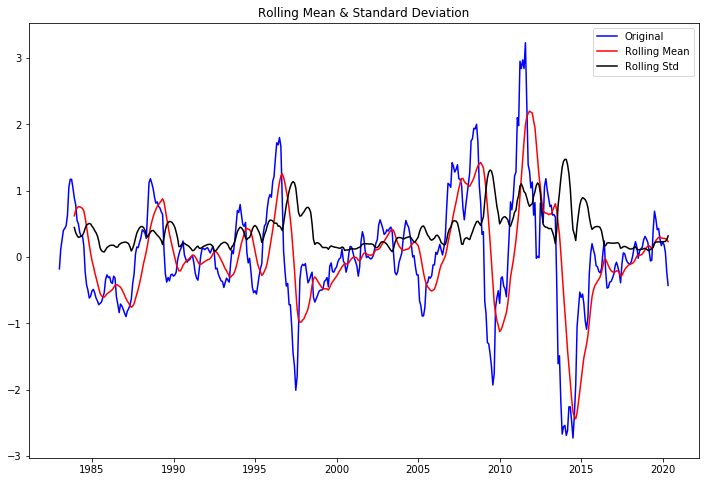

Results of Dickey-Fuller Test for:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    449.000000
Critical Value (1%)             -3.444998
Critical Value (5%)             -2.867999
Critical Value (10%)            -2.570210
dtype: float64
Ethanol


C:\Users\james\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\james\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\james\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


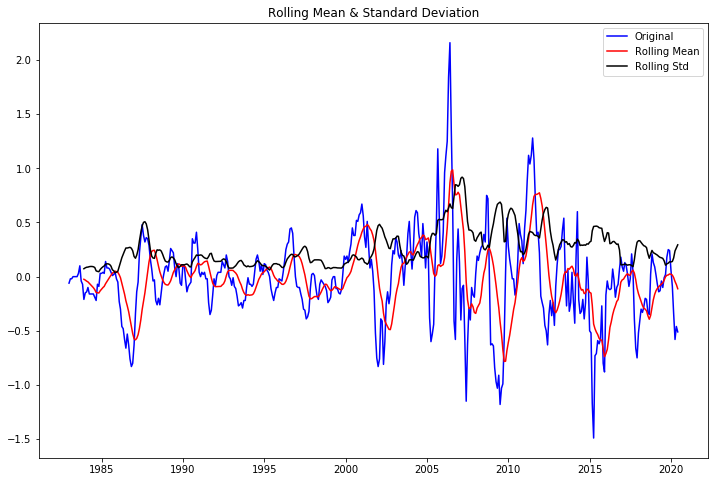

Results of Dickey-Fuller Test for:
Test Statistic                  -4.468985
p-value                          0.000224
#Lags Used                      14.000000
Number of Observations Used    435.000000
Critical Value (1%)             -3.445473
Critical Value (5%)             -2.868207
Critical Value (10%)            -2.570321
dtype: float64
Blender_cost


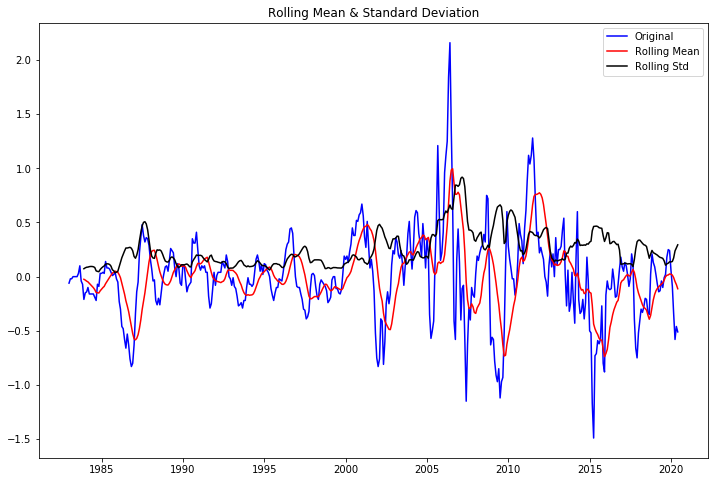

Results of Dickey-Fuller Test for:
Test Statistic                  -4.145479
p-value                          0.000814
#Lags Used                      14.000000
Number of Observations Used    435.000000
Critical Value (1%)             -3.445473
Critical Value (5%)             -2.868207
Critical Value (10%)            -2.570321
dtype: float64
Gasoline


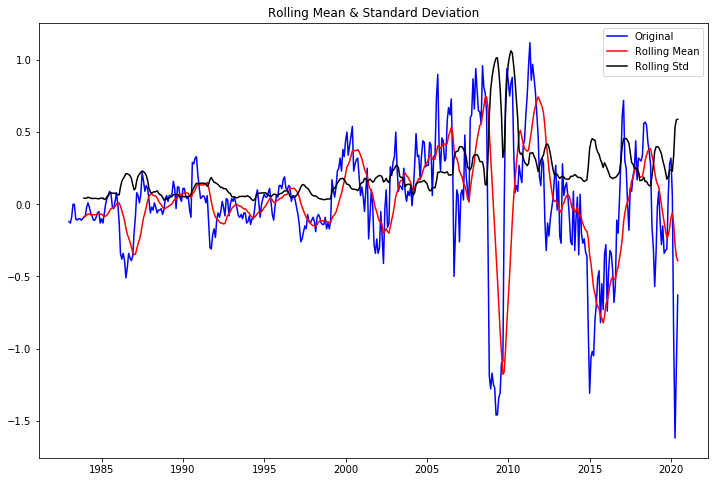

Results of Dickey-Fuller Test for:
Test Statistic                  -4.620526
p-value                          0.000118
#Lags Used                      18.000000
Number of Observations Used    431.000000
Critical Value (1%)             -3.445614
Critical Value (5%)             -2.868269
Critical Value (10%)            -2.570354
dtype: float64
Corn_cost_per_gallon


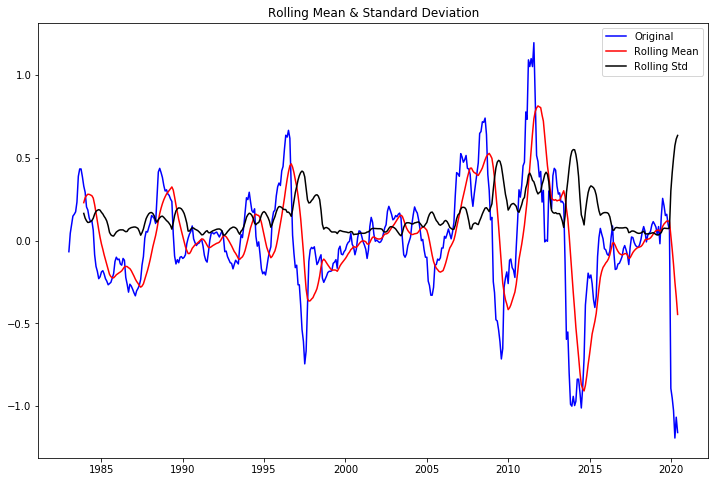

Results of Dickey-Fuller Test for:
Test Statistic                  -4.904155
p-value                          0.000034
#Lags Used                      18.000000
Number of Observations Used    431.000000
Critical Value (1%)             -3.445614
Critical Value (5%)             -2.868269
Critical Value (10%)            -2.570354
dtype: float64
Ethanol_geg


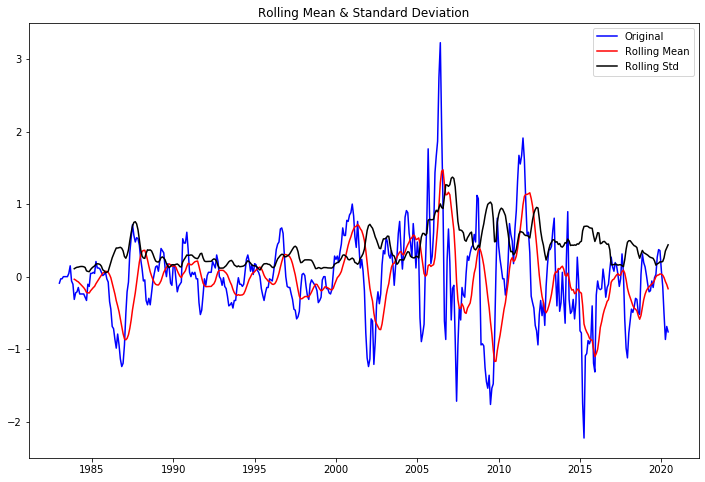

Results of Dickey-Fuller Test for:
Test Statistic                  -4.468985
p-value                          0.000224
#Lags Used                      14.000000
Number of Observations Used    435.000000
Critical Value (1%)             -3.445473
Critical Value (5%)             -2.868207
Critical Value (10%)            -2.570321
dtype: float64
Alcoholic beverages at home


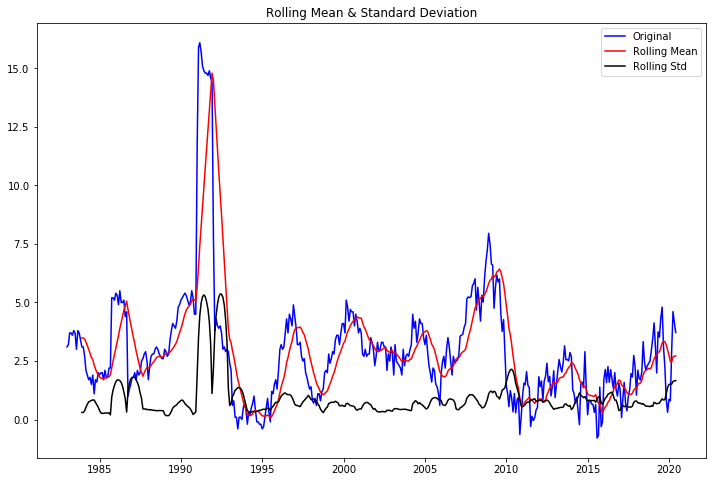

Results of Dickey-Fuller Test for:
Test Statistic                  -3.906645
p-value                          0.001986
#Lags Used                      15.000000
Number of Observations Used    434.000000
Critical Value (1%)             -3.445508
Critical Value (5%)             -2.868223
Critical Value (10%)            -2.570330
dtype: float64
Beef and veal


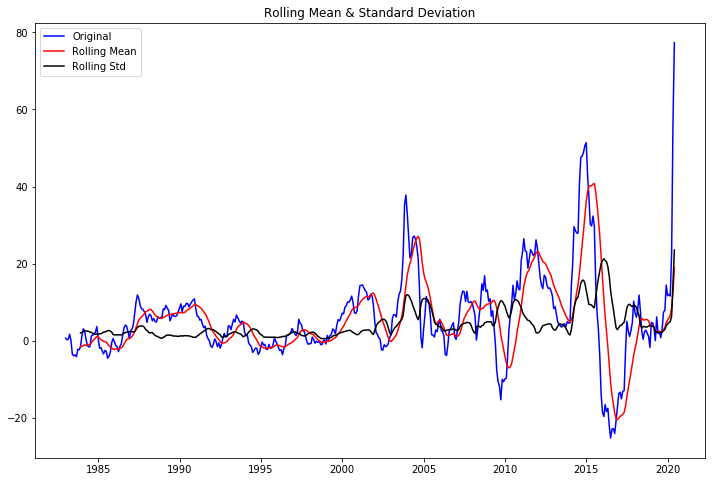

Results of Dickey-Fuller Test for:
Test Statistic                  -2.687045
p-value                          0.076307
#Lags Used                      13.000000
Number of Observations Used    436.000000
Critical Value (1%)             -3.445438
Critical Value (5%)             -2.868192
Critical Value (10%)            -2.570313
dtype: float64
Breakfast cereal


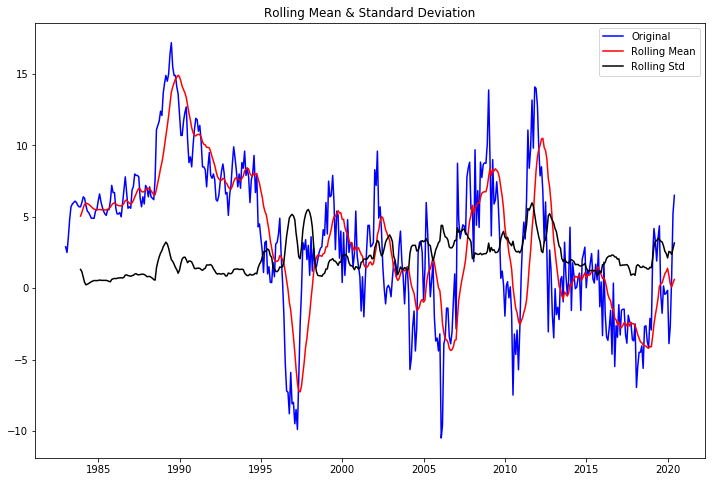

Results of Dickey-Fuller Test for:
Test Statistic                  -2.392508
p-value                          0.143862
#Lags Used                      13.000000
Number of Observations Used    436.000000
Critical Value (1%)             -3.445438
Critical Value (5%)             -2.868192
Critical Value (10%)            -2.570313
dtype: float64
Cakes, cupcakes, and cookies


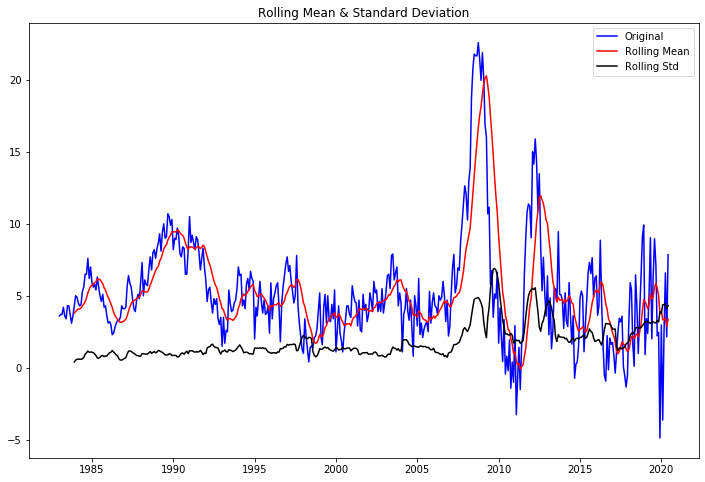

Results of Dickey-Fuller Test for:
Test Statistic                  -4.247140
p-value                          0.000548
#Lags Used                      12.000000
Number of Observations Used    437.000000
Critical Value (1%)             -3.445403
Critical Value (5%)             -2.868177
Critical Value (10%)            -2.570305
dtype: float64
Carbonated drinks


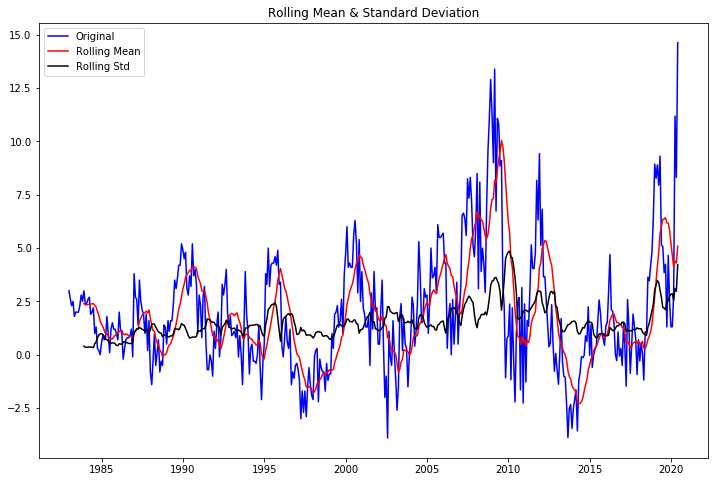

Results of Dickey-Fuller Test for:
Test Statistic                  -3.281937
p-value                          0.015705
#Lags Used                      18.000000
Number of Observations Used    431.000000
Critical Value (1%)             -3.445614
Critical Value (5%)             -2.868269
Critical Value (10%)            -2.570354
dtype: float64
Cereals and cereal products


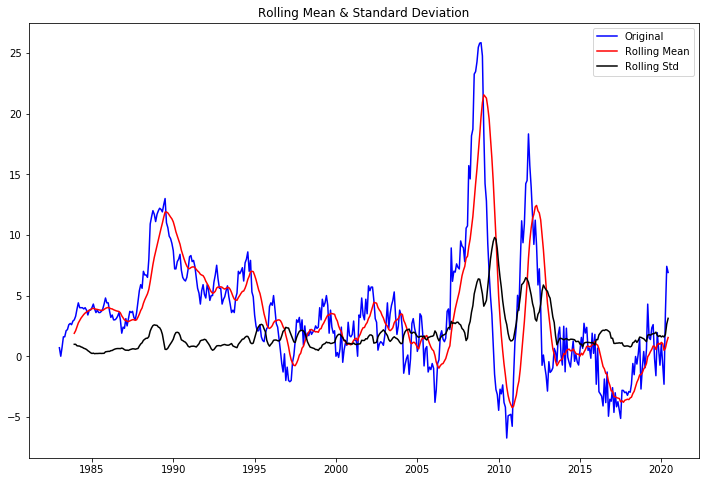

Results of Dickey-Fuller Test for:
Test Statistic                  -4.139655
p-value                          0.000832
#Lags Used                      16.000000
Number of Observations Used    433.000000
Critical Value (1%)             -3.445543
Critical Value (5%)             -2.868238
Critical Value (10%)            -2.570338
dtype: float64
Dairy and related products


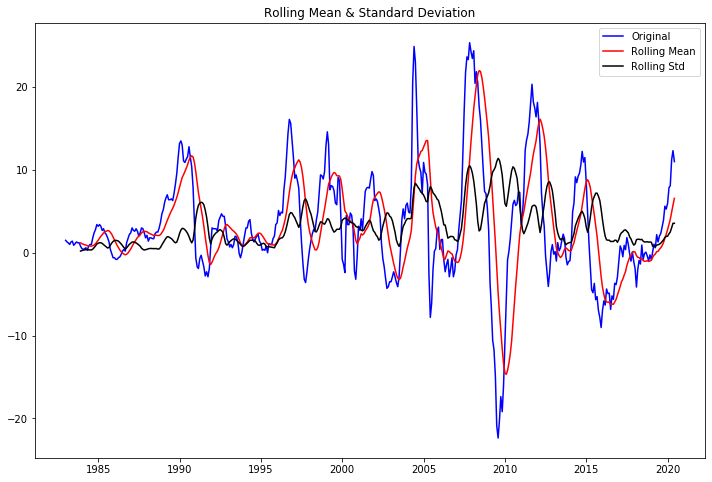

Results of Dickey-Fuller Test for:
Test Statistic                -6.268594e+00
p-value                        4.056288e-08
#Lags Used                     1.700000e+01
Number of Observations Used    4.320000e+02
Critical Value (1%)           -3.445578e+00
Critical Value (5%)           -2.868254e+00
Critical Value (10%)          -2.570346e+00
dtype: float64
Fats and oils


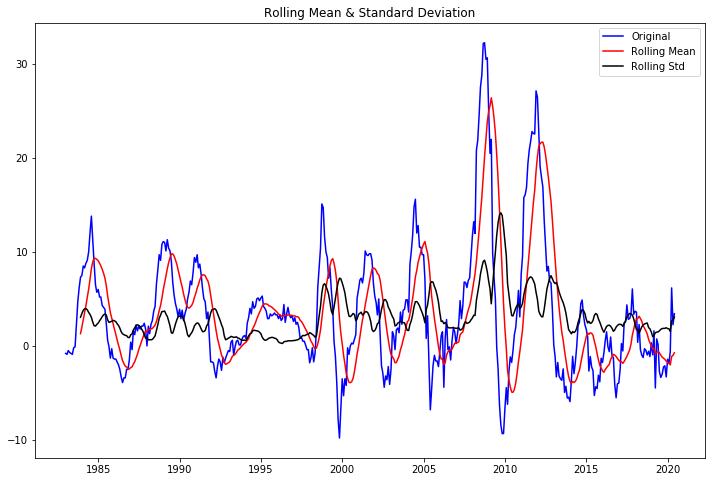

Results of Dickey-Fuller Test for:
Test Statistic                  -5.217071
p-value                          0.000008
#Lags Used                      16.000000
Number of Observations Used    433.000000
Critical Value (1%)             -3.445543
Critical Value (5%)             -2.868238
Critical Value (10%)            -2.570338
dtype: float64
Fish and seafood


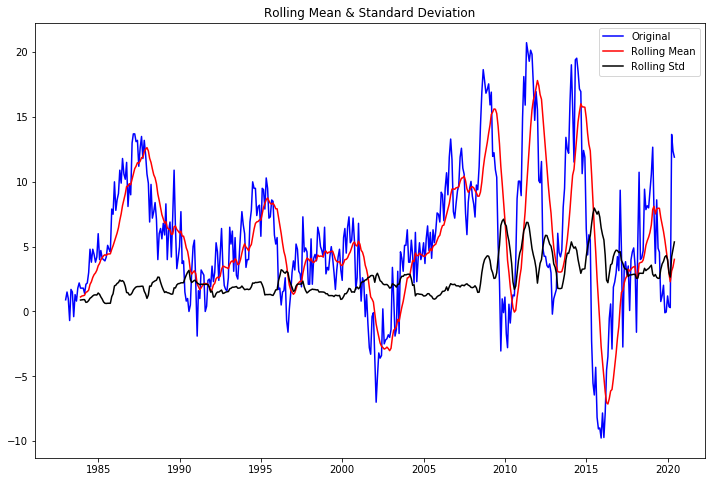

Results of Dickey-Fuller Test for:
Test Statistic                  -3.316014
p-value                          0.014178
#Lags Used                      16.000000
Number of Observations Used    433.000000
Critical Value (1%)             -3.445543
Critical Value (5%)             -2.868238
Critical Value (10%)            -2.570338
dtype: float64
Flour and prepared flour mixes


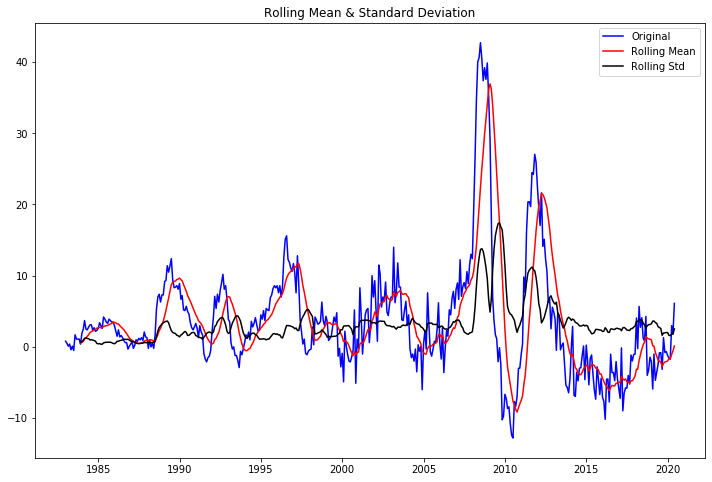

Results of Dickey-Fuller Test for:
Test Statistic                  -4.669116
p-value                          0.000096
#Lags Used                      15.000000
Number of Observations Used    434.000000
Critical Value (1%)             -3.445508
Critical Value (5%)             -2.868223
Critical Value (10%)            -2.570330
dtype: float64
Food


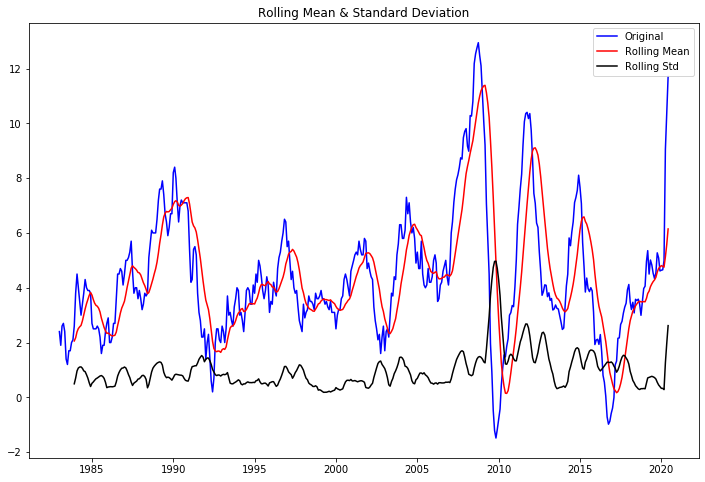

Results of Dickey-Fuller Test for:
Test Statistic                  -4.555883
p-value                          0.000156
#Lags Used                      18.000000
Number of Observations Used    431.000000
Critical Value (1%)             -3.445614
Critical Value (5%)             -2.868269
Critical Value (10%)            -2.570354
dtype: float64
Frozen vegetables


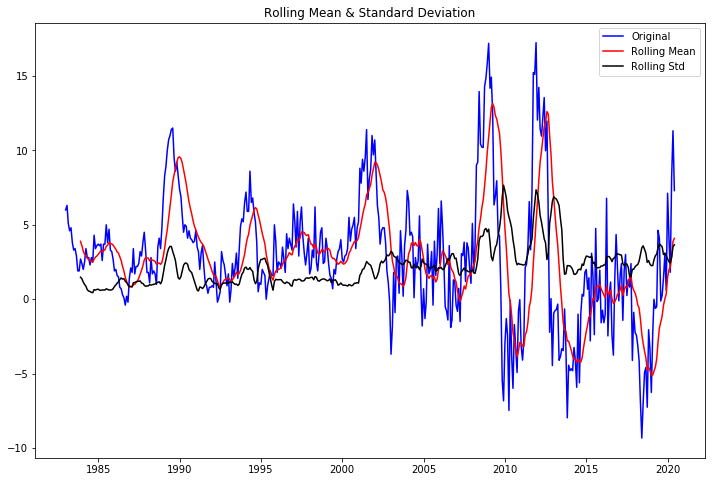

Results of Dickey-Fuller Test for:
Test Statistic                  -4.437082
p-value                          0.000255
#Lags Used                      13.000000
Number of Observations Used    436.000000
Critical Value (1%)             -3.445438
Critical Value (5%)             -2.868192
Critical Value (10%)            -2.570313
dtype: float64
Fruits and vegetables


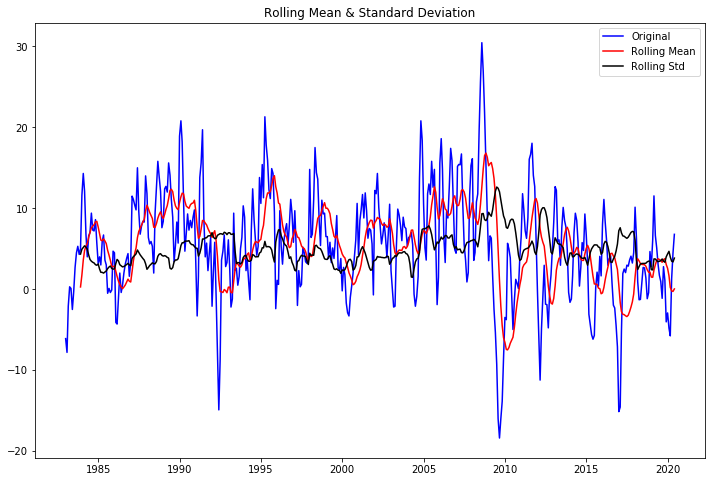

Results of Dickey-Fuller Test for:
Test Statistic                  -4.039423
p-value                          0.001218
#Lags Used                      17.000000
Number of Observations Used    432.000000
Critical Value (1%)             -3.445578
Critical Value (5%)             -2.868254
Critical Value (10%)            -2.570346
dtype: float64
Ham


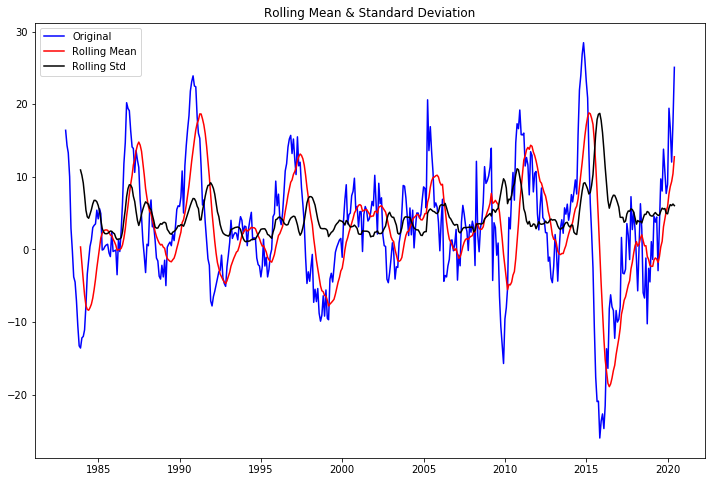

Results of Dickey-Fuller Test for:
Test Statistic                -5.892100e+00
p-value                        2.908201e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.310000e+02
Critical Value (1%)           -3.445614e+00
Critical Value (5%)           -2.868269e+00
Critical Value (10%)          -2.570354e+00
dtype: float64
Meats


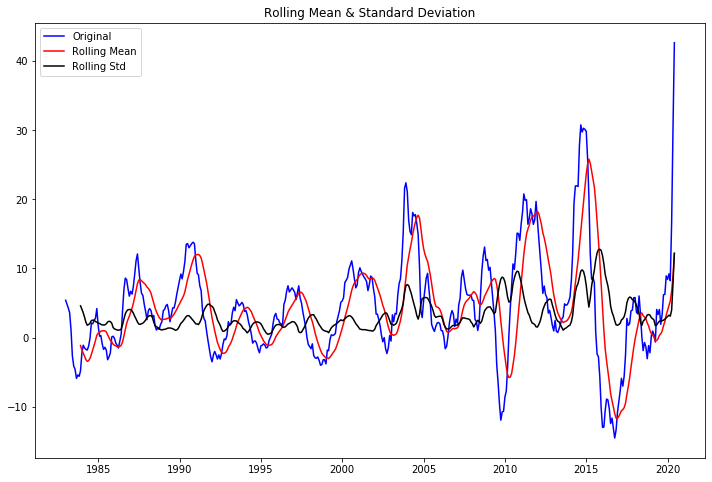

Results of Dickey-Fuller Test for:
Test Statistic                  -3.442433
p-value                          0.009595
#Lags Used                      13.000000
Number of Observations Used    436.000000
Critical Value (1%)             -3.445438
Critical Value (5%)             -2.868192
Critical Value (10%)            -2.570313
dtype: float64
Poultry


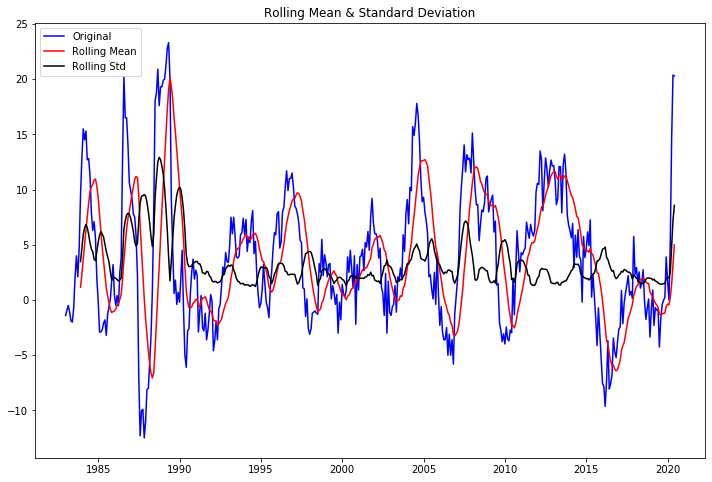

Results of Dickey-Fuller Test for:
Test Statistic                  -4.373811
p-value                          0.000330
#Lags Used                      12.000000
Number of Observations Used    437.000000
Critical Value (1%)             -3.445403
Critical Value (5%)             -2.868177
Critical Value (10%)            -2.570305
dtype: float64
Rice, pasta, cornmeal


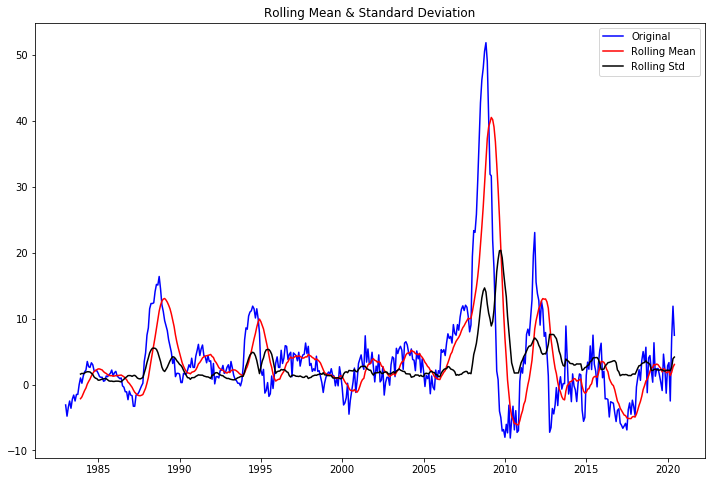

Results of Dickey-Fuller Test for:
Test Statistic                  -4.372158
p-value                          0.000332
#Lags Used                      16.000000
Number of Observations Used    433.000000
Critical Value (1%)             -3.445543
Critical Value (5%)             -2.868238
Critical Value (10%)            -2.570338
dtype: float64


In [37]:
for i in FF1_annual_change2.columns:
    print (i)
    test_stationarity(FF1_annual_change2[i])
    